In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Define

In [16]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Những segment có F1 > 0.5 thì coi như detect được

In [3]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,anomaly_idx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    anomaly = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    anomaly[anomaly_idx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(anomaly, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(anomaly, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(anomaly, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(anomaly, pred))
    
    accuracy = (tp + tn) / len(anomaly)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    result ={'Metrics':['Accuracy' ,'Precision','Recall','F1-score' ],
             'Score':[accuracy,precision, recall, f1]}
    result = pd.DataFrame(result)
    display(result.T)
    return accuracy,precision,recall,f1

# Data

## Without noise

In [90]:
num_datapoints = 8640
time_index = pd.date_range(start='2024-01-01', periods=num_datapoints, freq='s')

In [105]:
mean_traffic = 100 
std_dev_traffic = 0.02
x = np.arange(8640)/5184+10
traffic_data = np.random.normal(loc=mean_traffic, scale=std_dev_traffic, size=num_datapoints)
traffic_data = traffic_data + np.sin(x**2.5)**7
network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data},index=time_index)


## add noise

In [106]:
time_range_1 = pd.to_datetime('2024-01-01 01:00:00')
time_range_2 = pd.to_datetime('2024-01-01 01:06:00')
time_range_3 = pd.to_datetime('2024-01-01 01:12:00')

start_noise_ = network_traffic_df.loc[time_range_1:time_range_2].Traffic_Mbps.idxmin()
end_noise_ = network_traffic_df.loc[time_range_2:time_range_3].Traffic_Mbps.idxmin()
start_noise_,end_noise_

(Timestamp('2024-01-01 01:01:26', freq='S'),
 Timestamp('2024-01-01 01:07:32', freq='S'))

In [107]:
60*60+60*1+25

3685

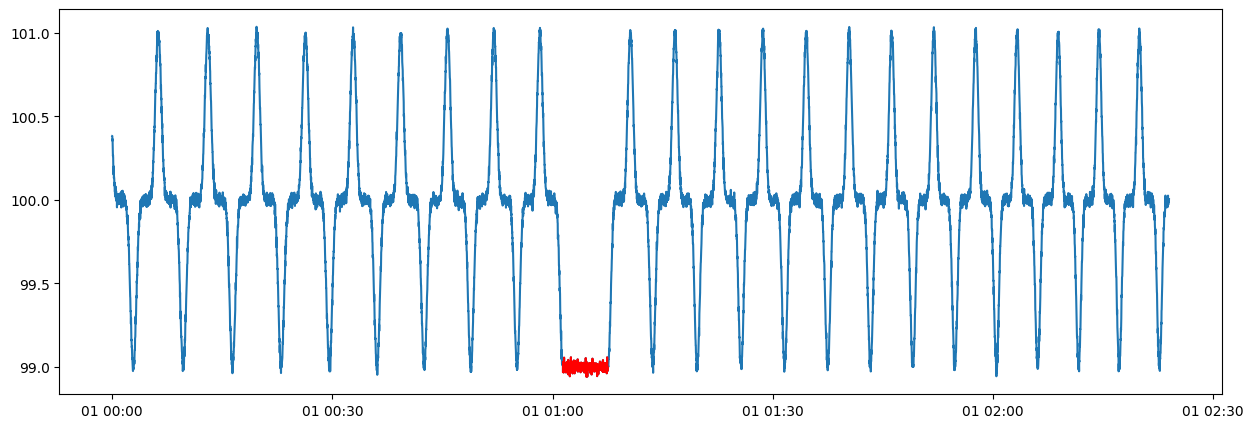

In [109]:
start_noise_period = 3685   #start_noise_ : 60*60+60*1+25
end_noise_period = 4051    #end_noise_ : 60*60+60*7+31
noise_size = end_noise_period - start_noise_period
noise_level = 99

noise = np.random.normal(loc=(np.full(noise_size,noise_level)), scale=std_dev_traffic, size=noise_size)
traffic_data[start_noise_period:end_noise_period] = noise

network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data},index=time_index)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(network_traffic_df)
ax.plot(network_traffic_df[start_noise_period:end_noise_period],c='r')

In [9]:
anomaly_idx = list(np.arange(start_noise_period,end_noise_period))

# Feature

In [11]:
ts = pd.DataFrame(network_traffic_df['Traffic_Mbps'])
ts['id'] = 1

In [12]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_value='Traffic_Mbps')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:08<00:00, 68.44s/it]


In [13]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=['Traffic_Mbps__mean',
                                                                     'Traffic_Mbps__median',
                                                                     'Traffic_Mbps__variance',
                                                                     'Traffic_Mbps__standard_deviation',
                                                                     'Traffic_Mbps__absolute_sum_of_changes',
                                                                     'Traffic_Mbps__mean_abs_change',
                                                                     'Traffic_Mbps__kurtosis',
                                                                     'Traffic_Mbps__minimum',
                                                                     'Traffic_Mbps__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: 'Traffic_Mbps'})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','absolute_sum_of_changes','mean_abs_change',
                                      'kurtosis','minimum','maximum']

In [14]:
extracted_relevant_feature

,Traffic_Mbps
mean,99.951207
median,99.996803
variance,0.240128
standard_deviation,0.490029
absolute_sum_of_changes,217.890120
mean_abs_change,0.025222
kurtosis,0.123460
minimum,98.939642
maximum,101.066830


# Top-down

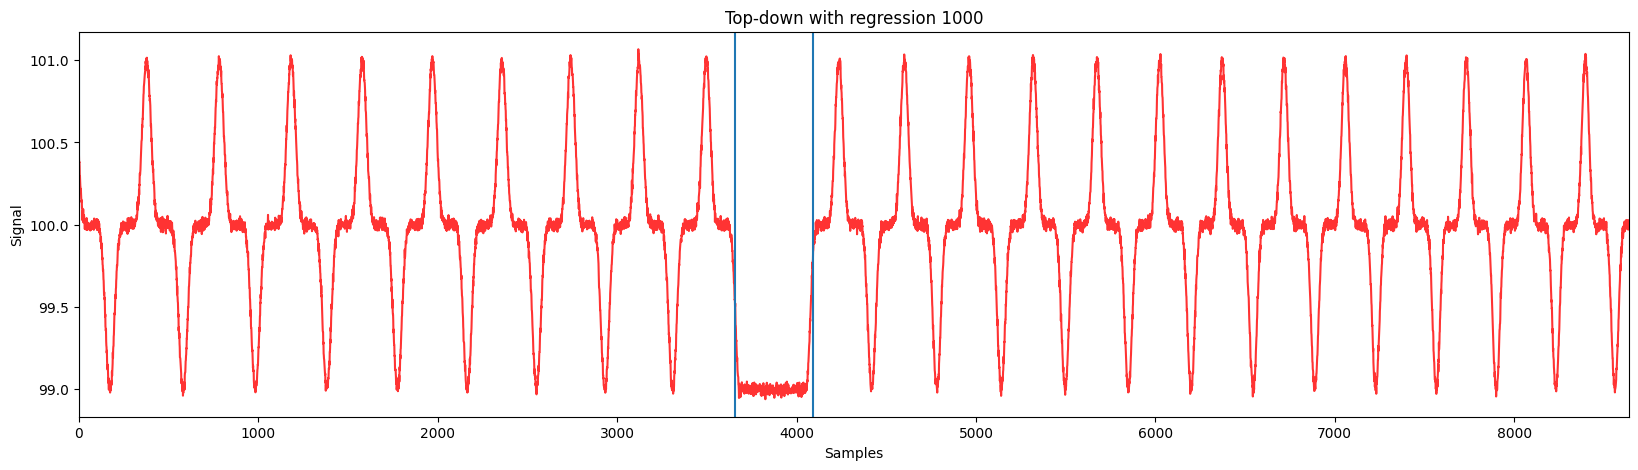

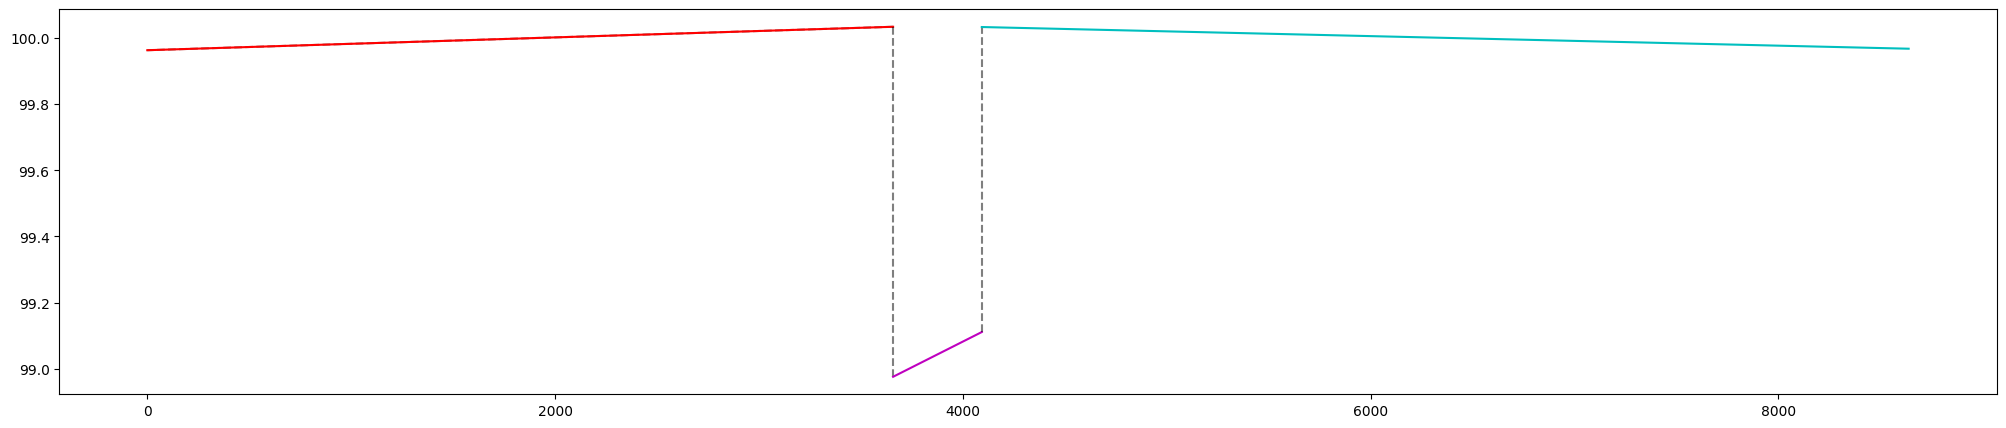

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.992014,0.841379,1.0,0.913858


In [33]:
max_error = 1000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

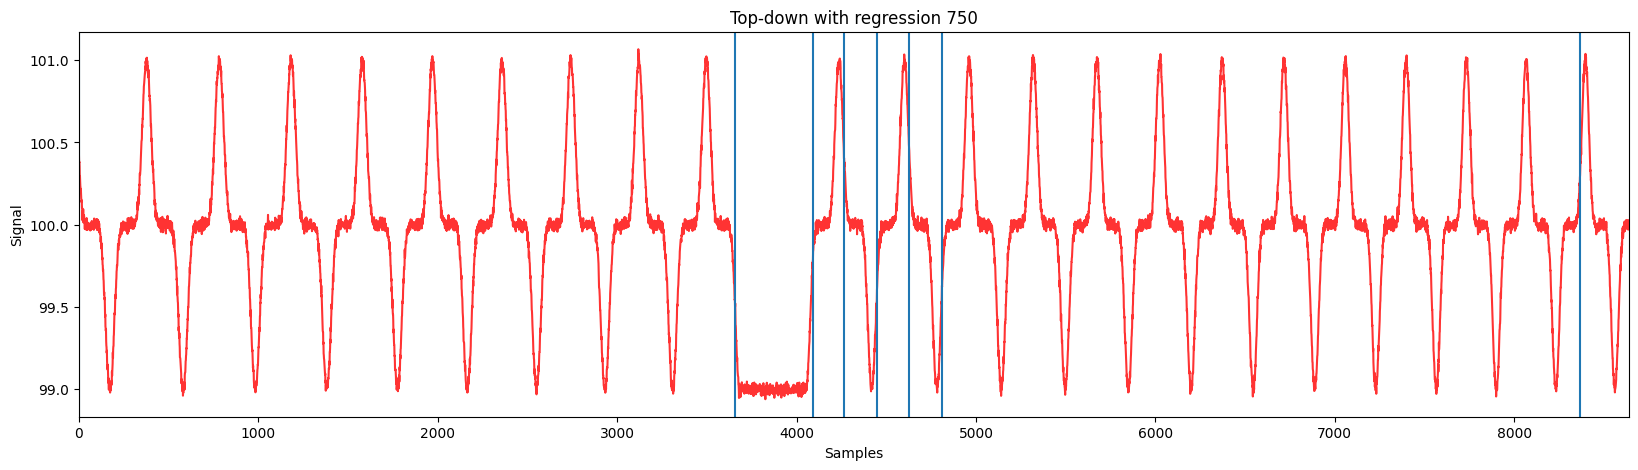

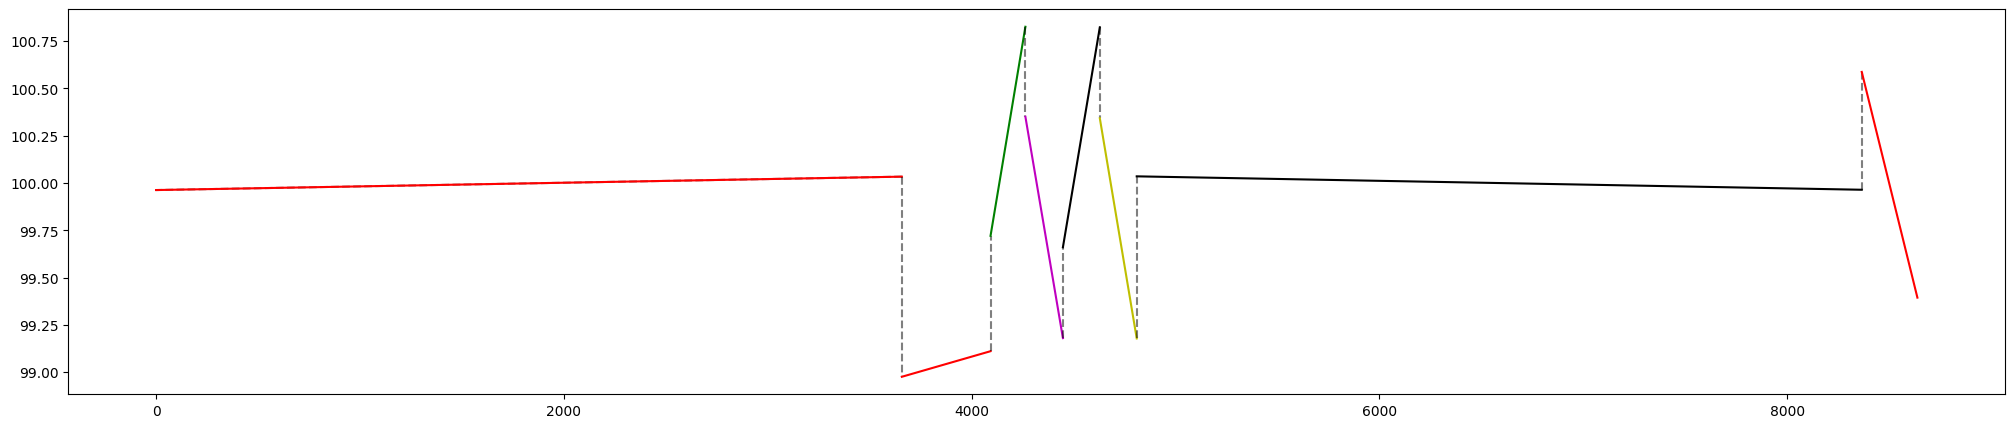

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.992014,0.841379,1.0,0.913858


In [34]:
max_error = 750
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

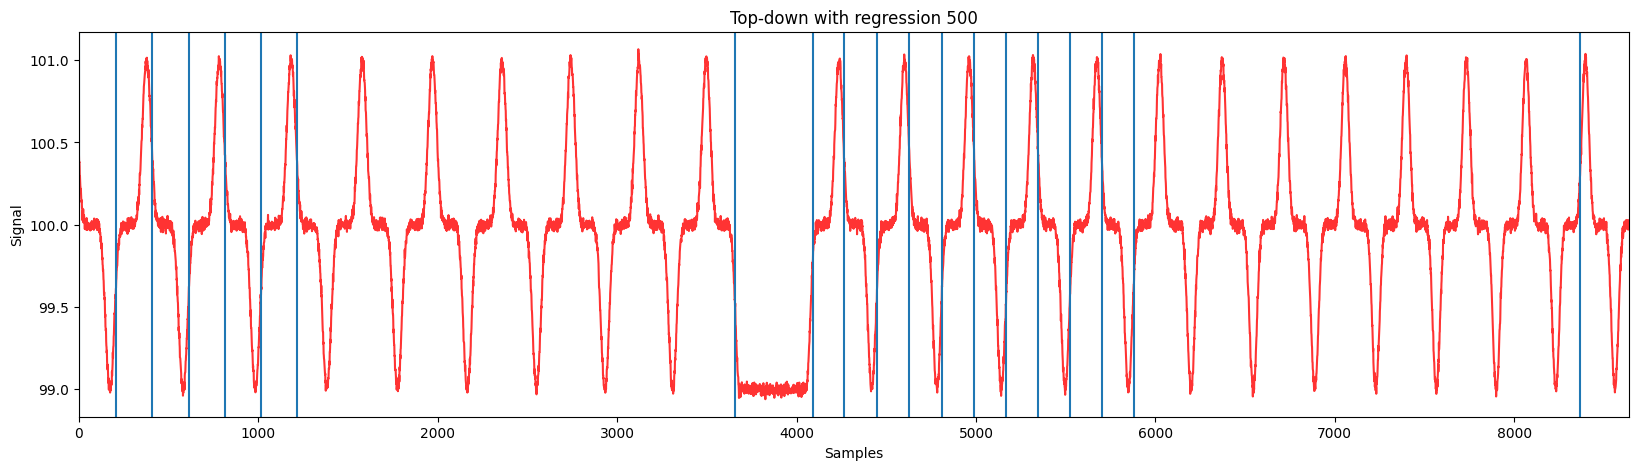

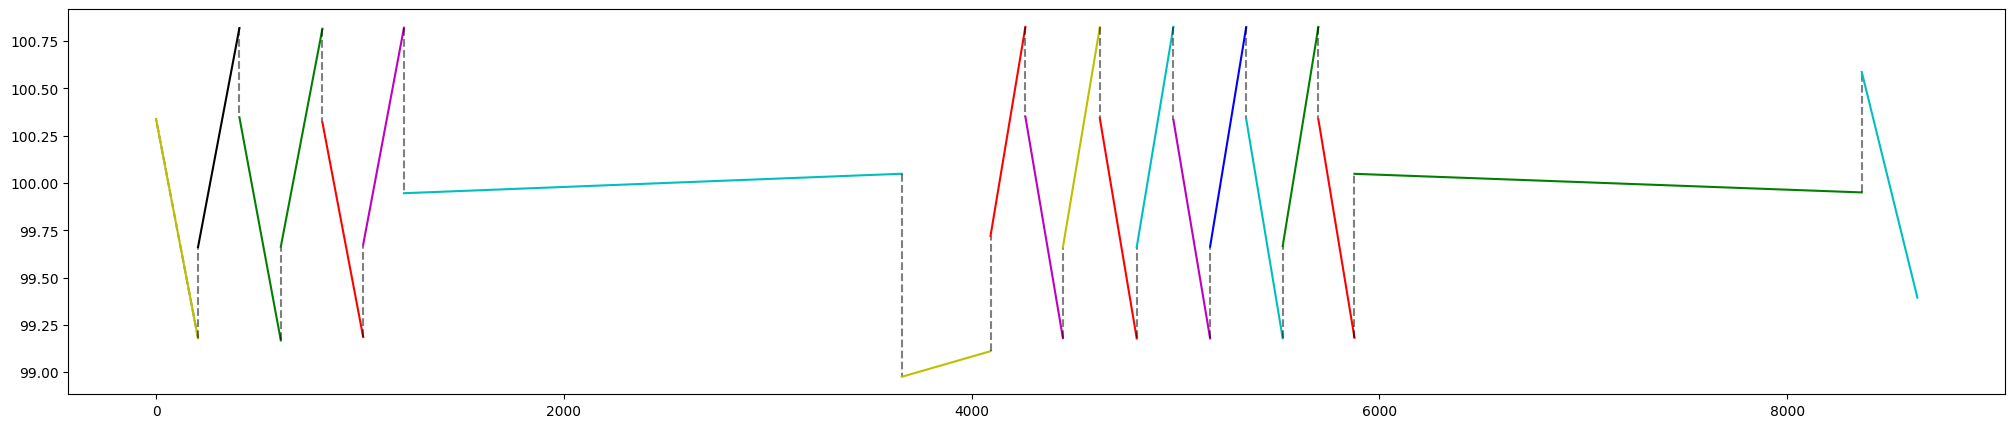

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.992014,0.841379,1.0,0.913858


In [26]:
max_error = 500
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [35]:
range_max_error_topdown = (500,1000)
best_Top_down = 1000
time_avg_Top_down = (49.3+29.3+15.2)/3

# Bottom-up

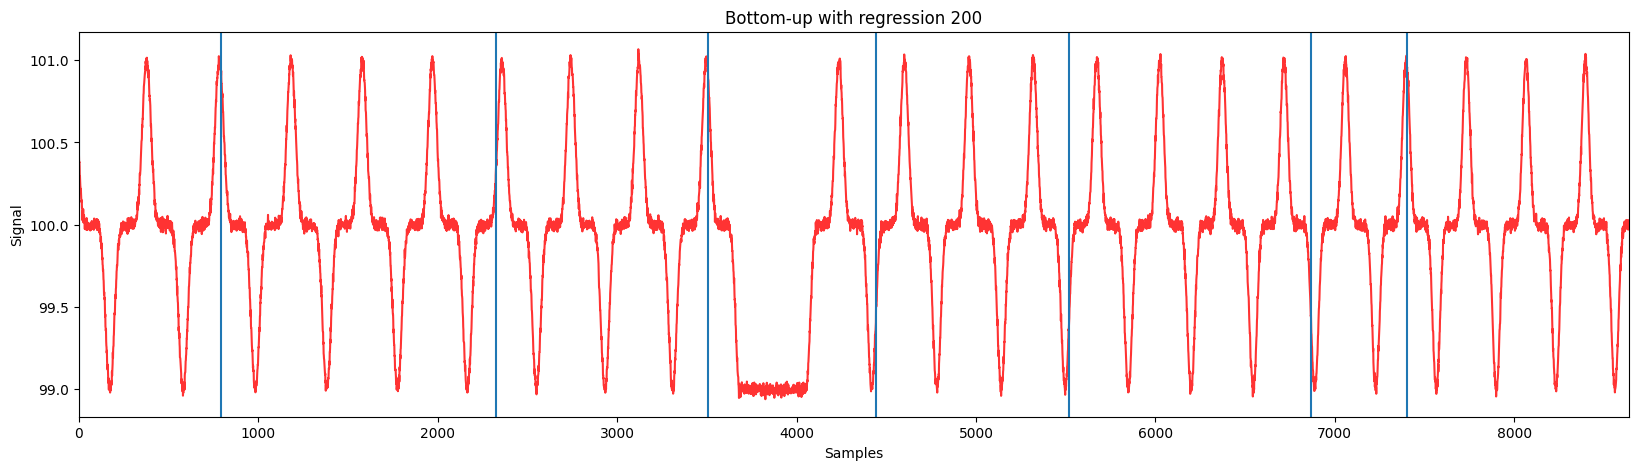

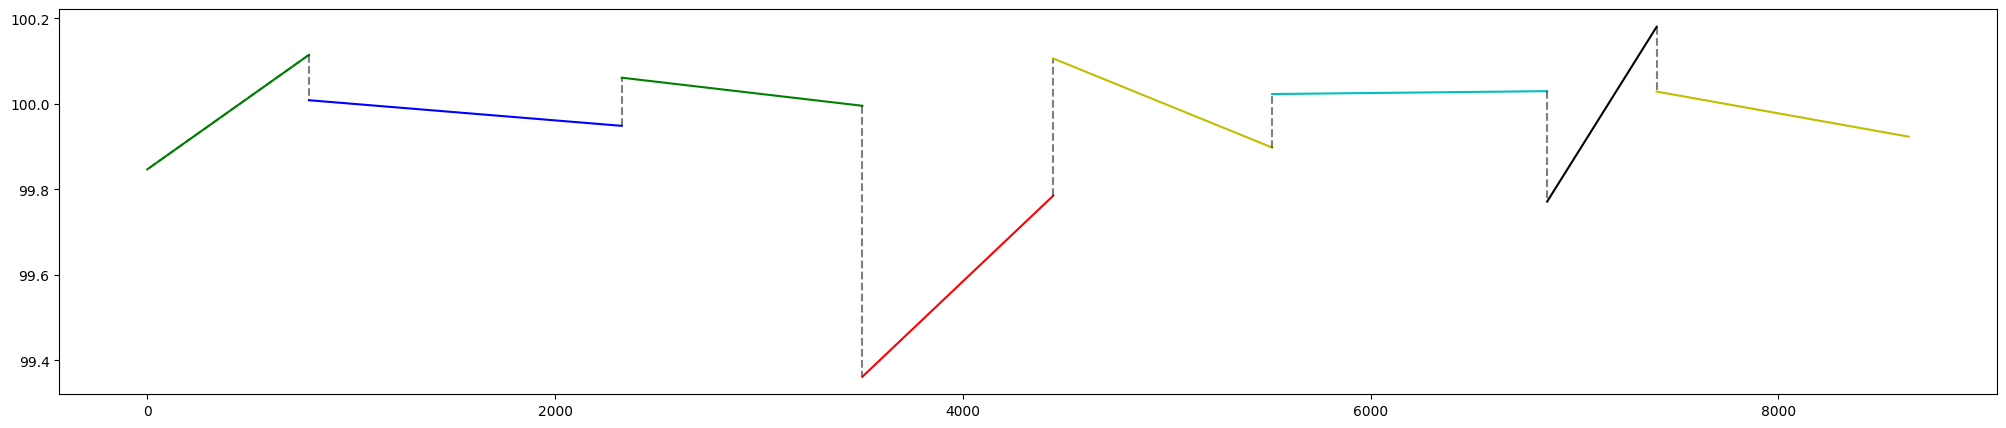

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.934028,0.391026,1.0,0.562212


In [37]:
max_error = 200
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

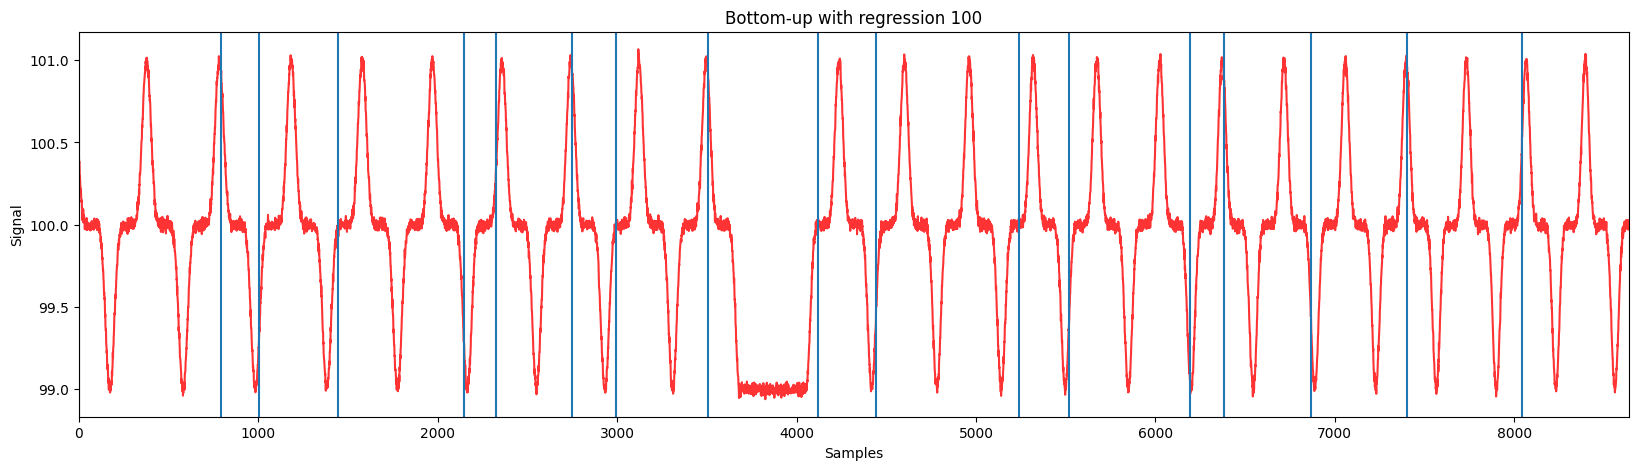

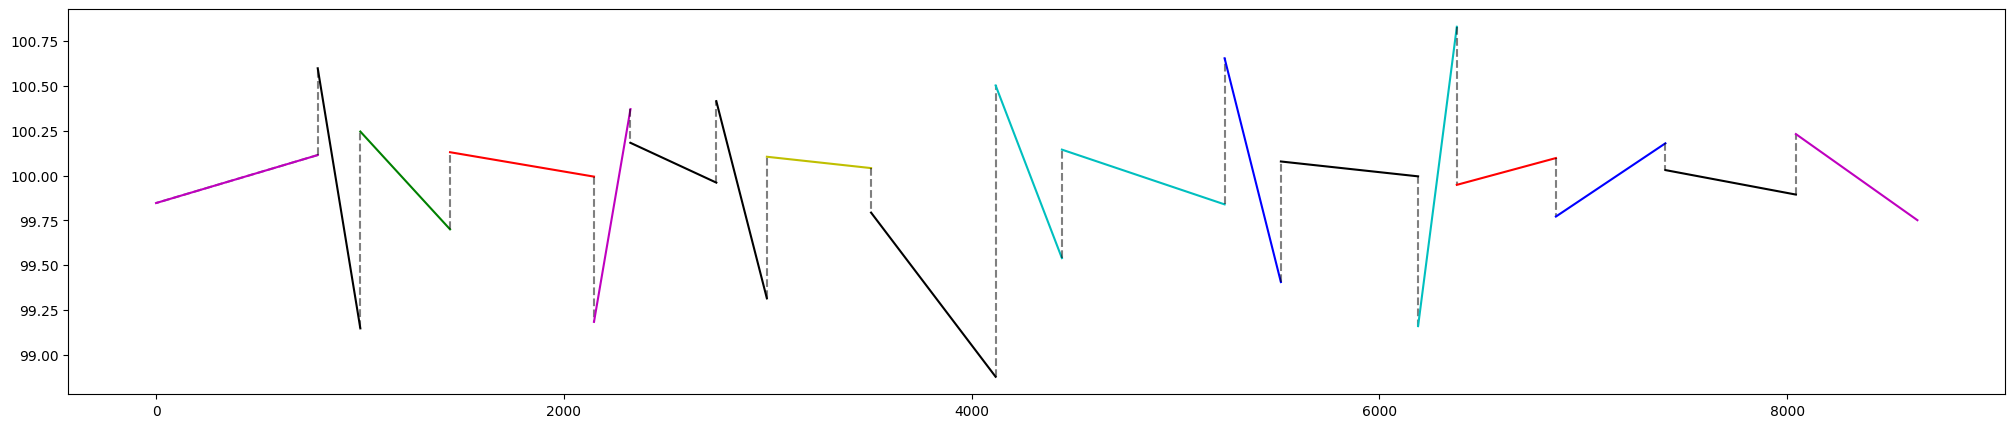

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.971644,0.599018,1.0,0.749232


In [66]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

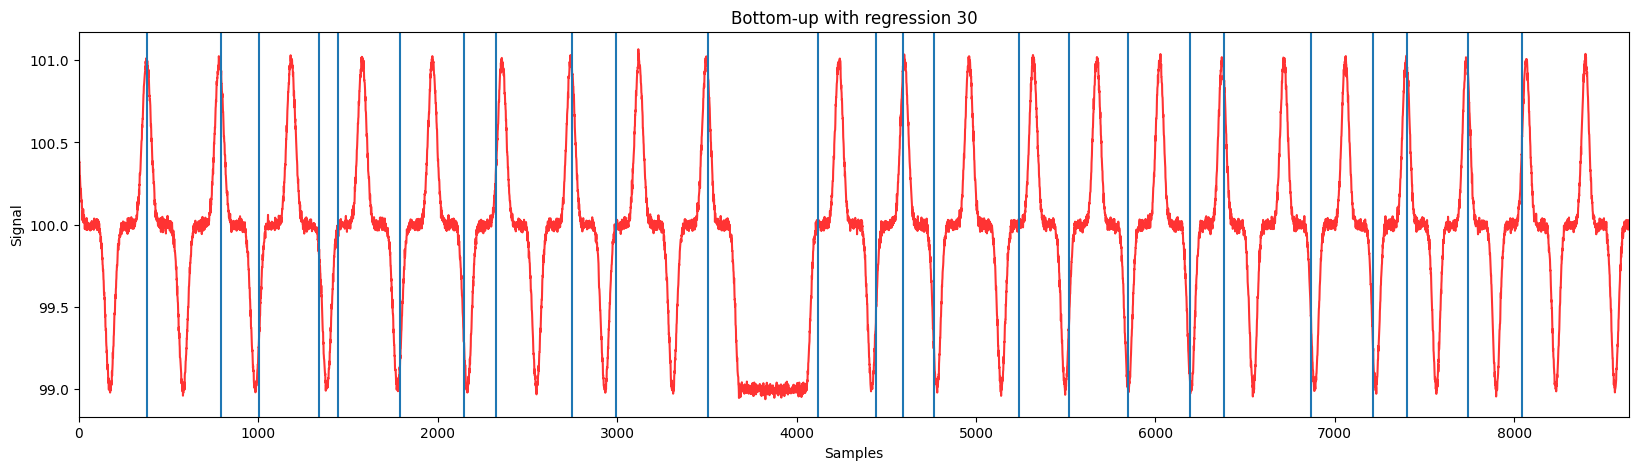

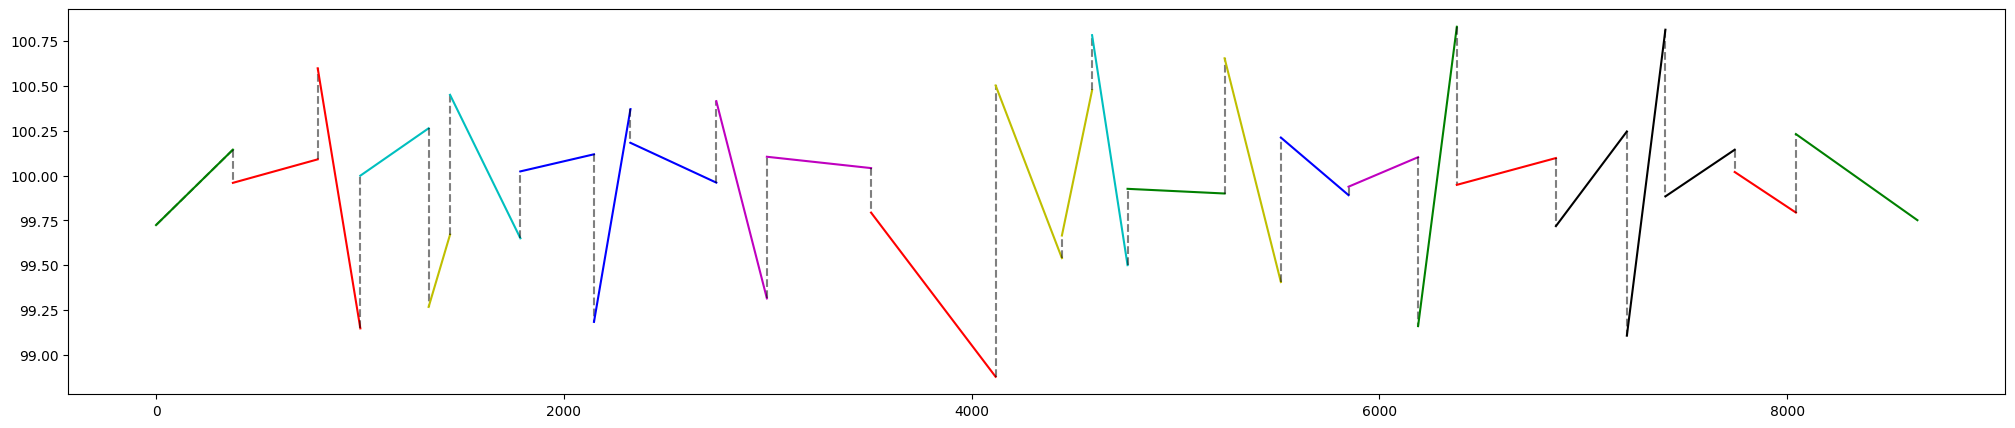

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.971644,0.599018,1.0,0.749232


In [44]:
max_error = 30
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [46]:
range_max_error_bottomup = (30,200)
best_Bottom_up = 100
time_avg_Bottom_up = (5.5+5.49+5.61)/3

# Sliding window

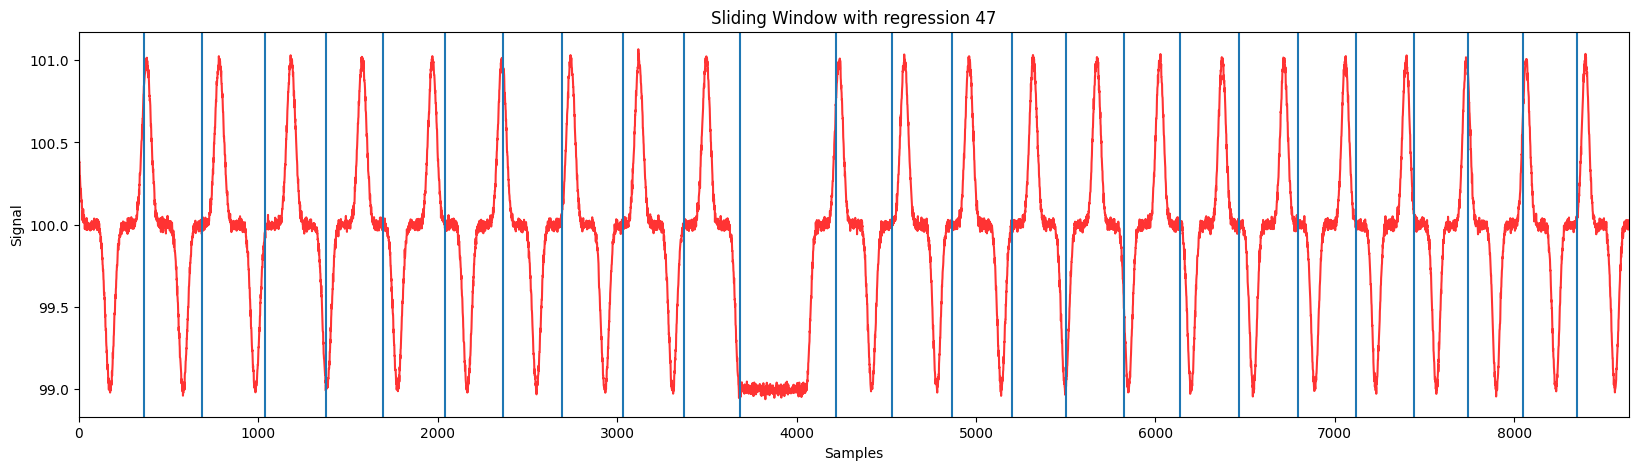

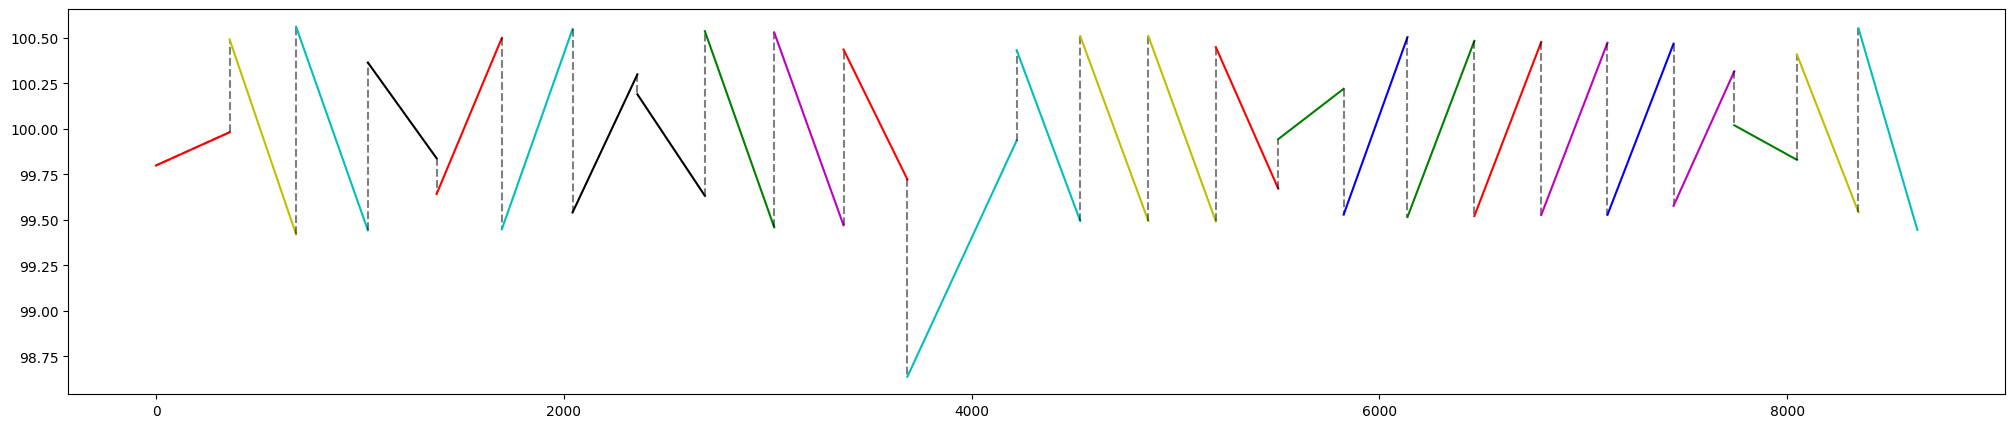

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.921412,0.0,0.0,0.0


In [62]:
max_error = 47
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

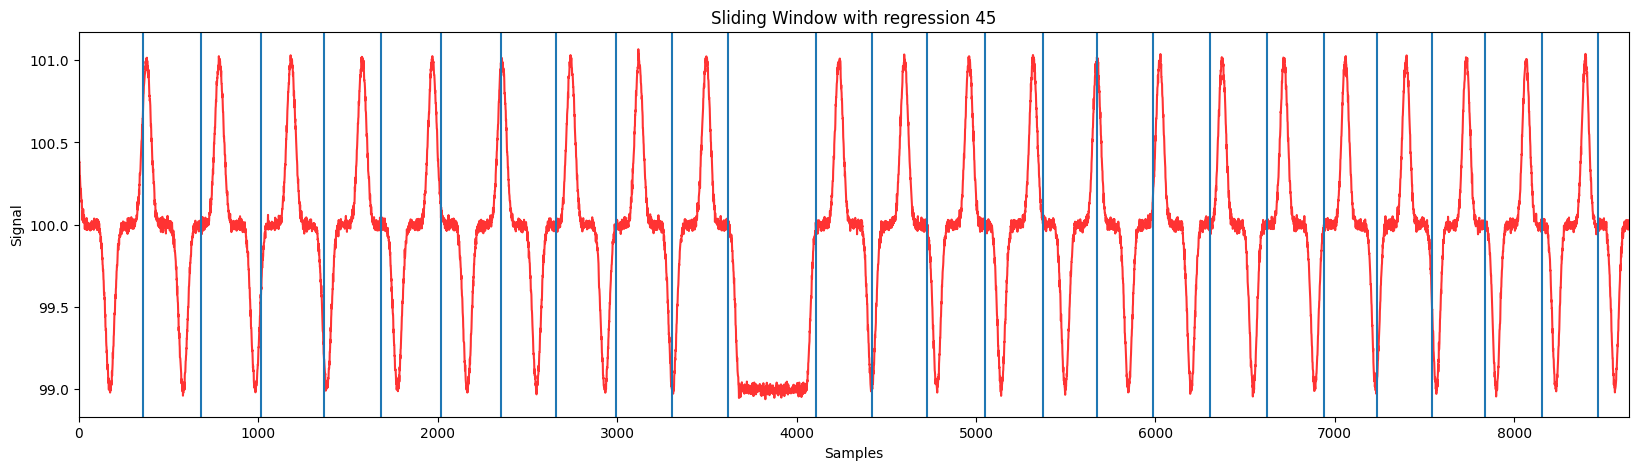

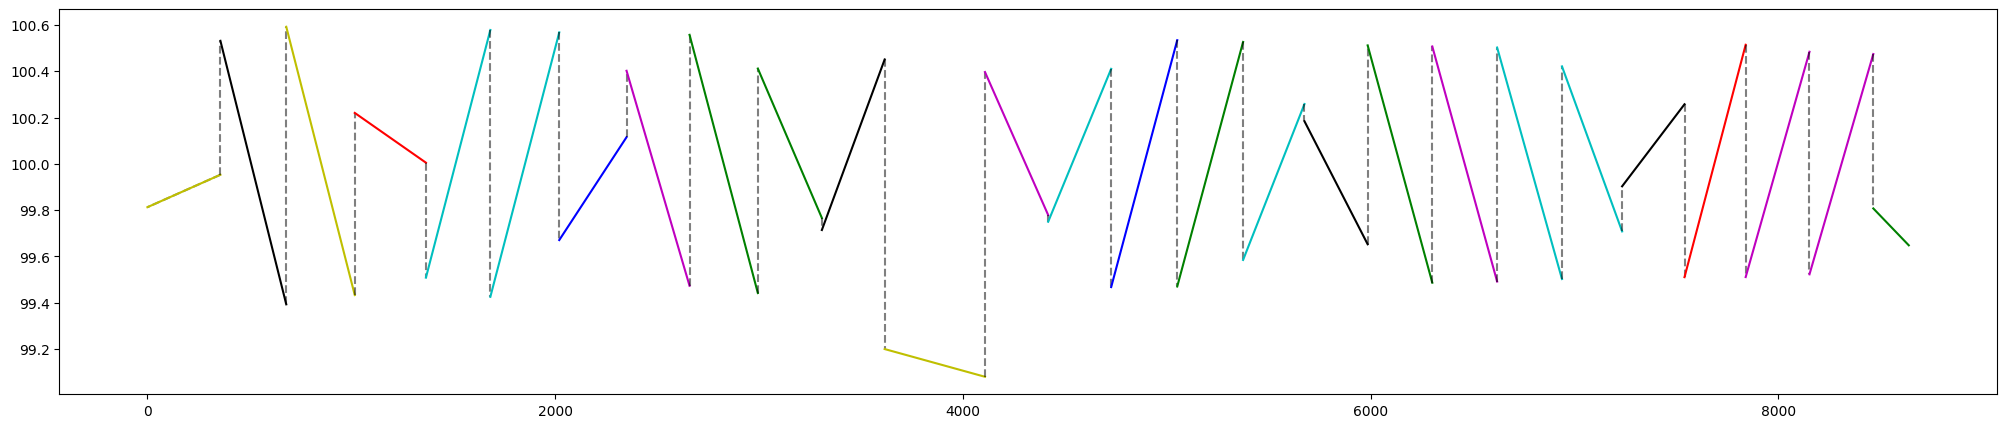

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.985417,0.743902,1.0,0.853147


In [65]:
max_error = 45
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw  = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

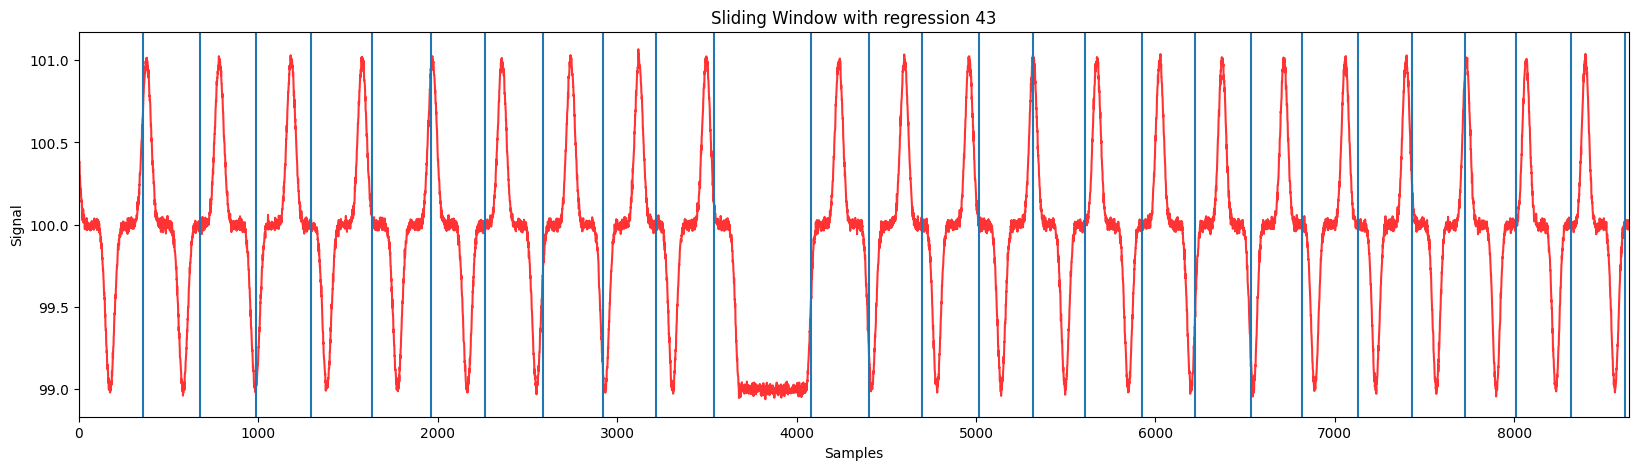

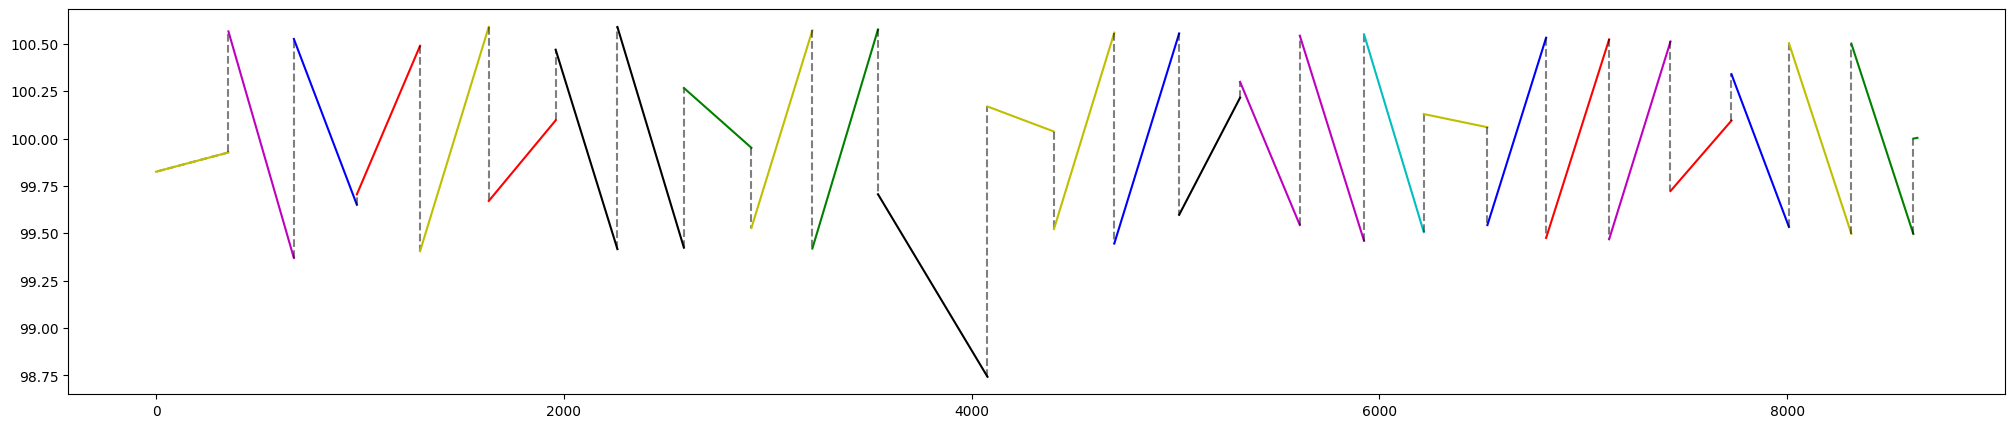

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.980208,0.681564,1.0,0.810631


In [59]:
max_error = 43
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [64]:
range_max_error_sldw = (43,47)
best_sliding_window = 45
time_avg_sliding_window = (1.61+1.55+1.56)/3

# SWAB

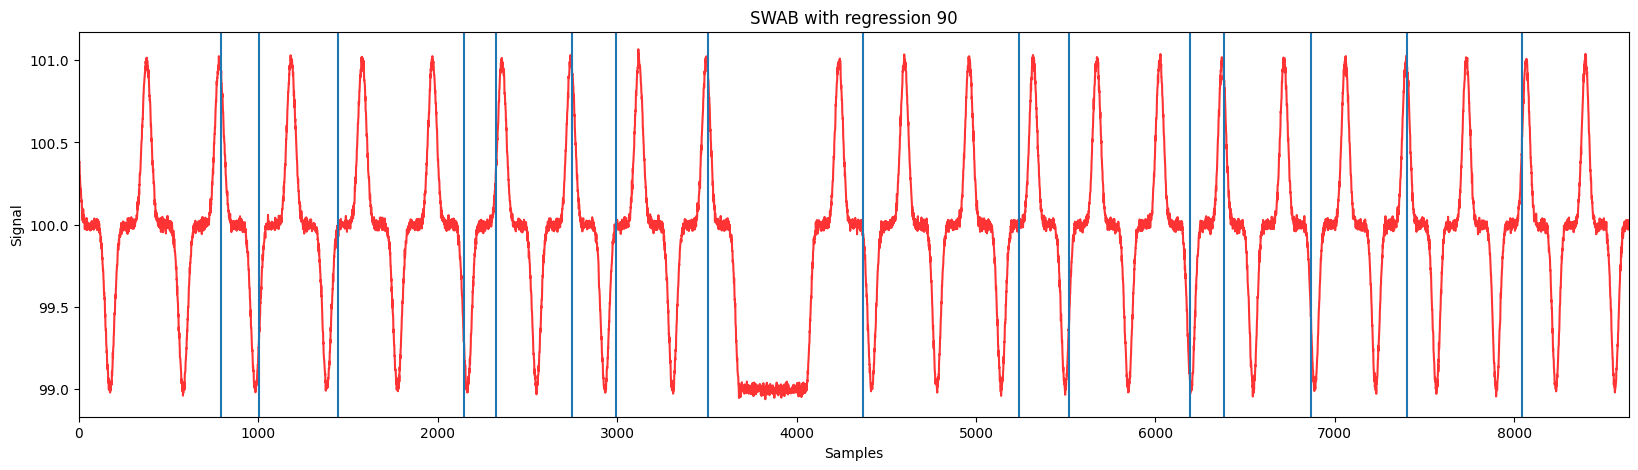

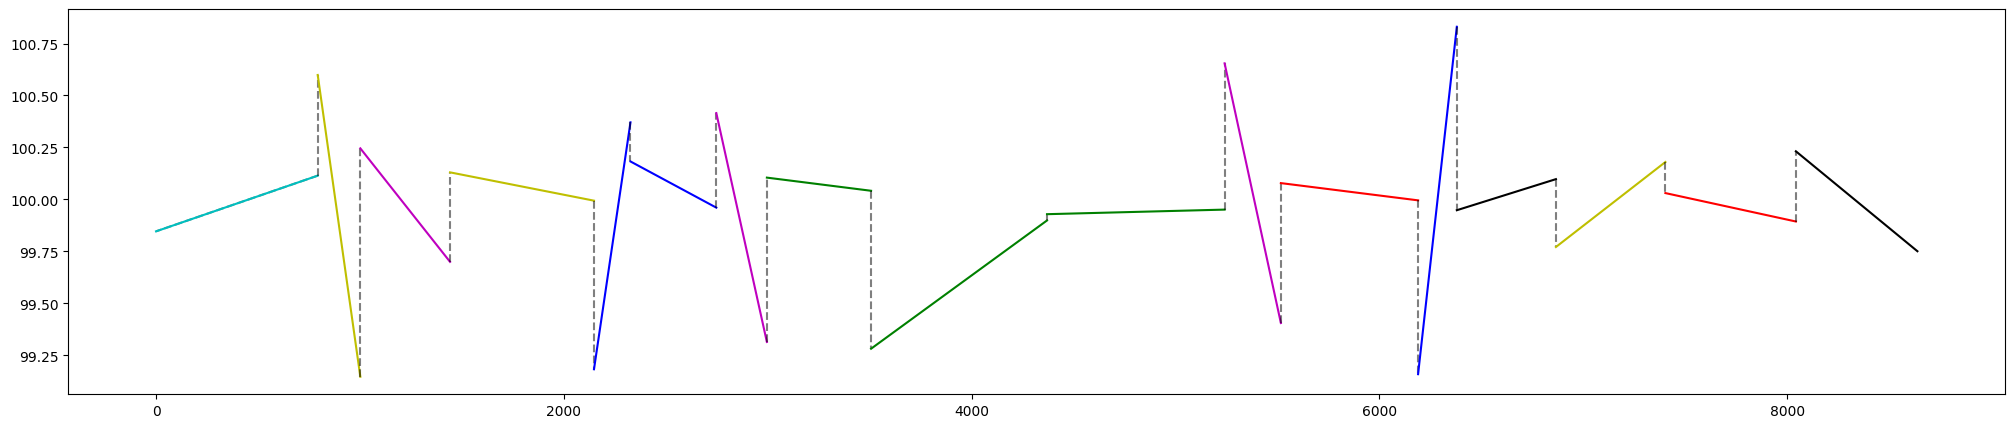

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.898495,0.0,0.0,0.0


In [74]:
max_error = 90
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

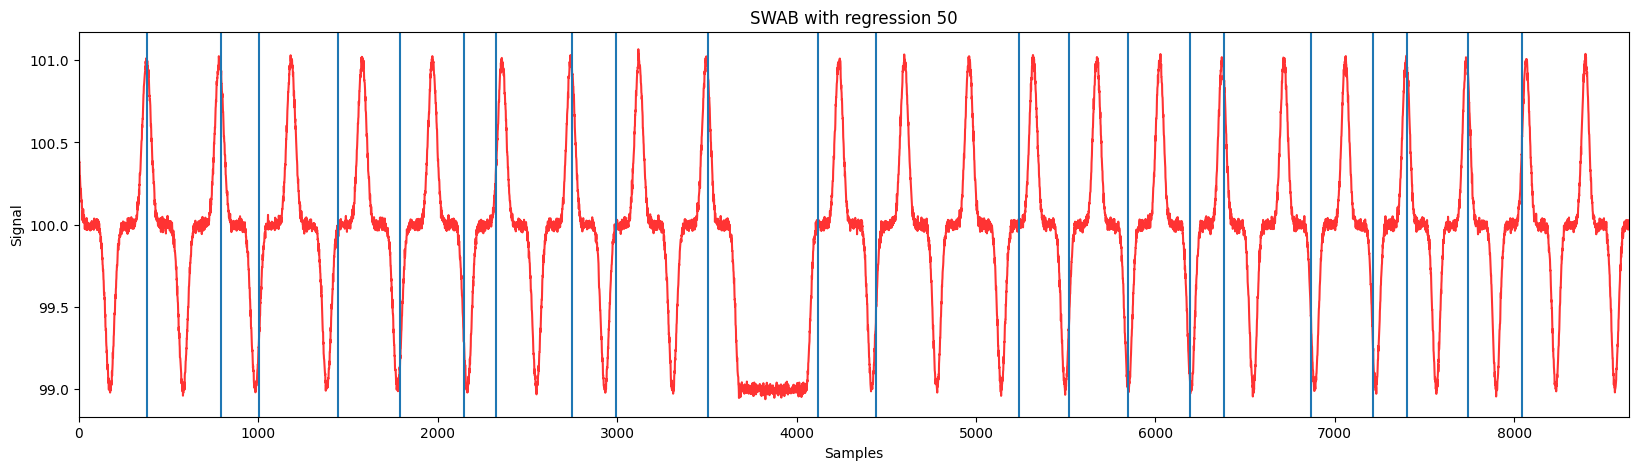

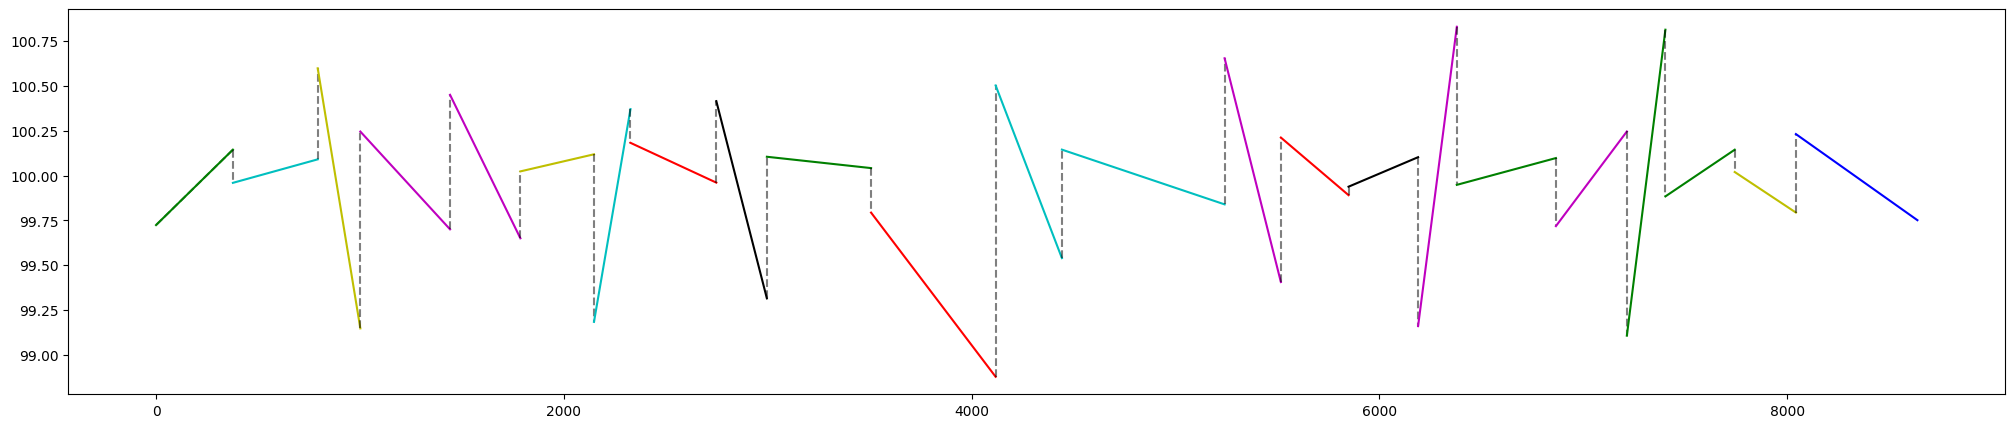

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.971644,0.599018,1.0,0.749232


In [77]:
max_error = 50
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

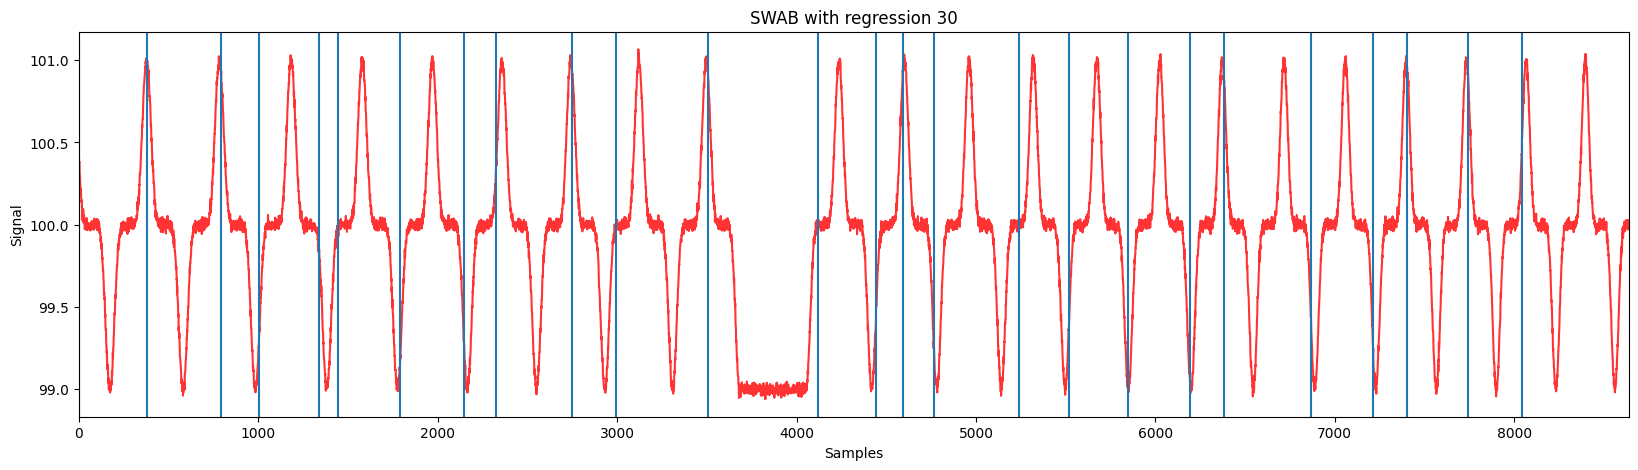

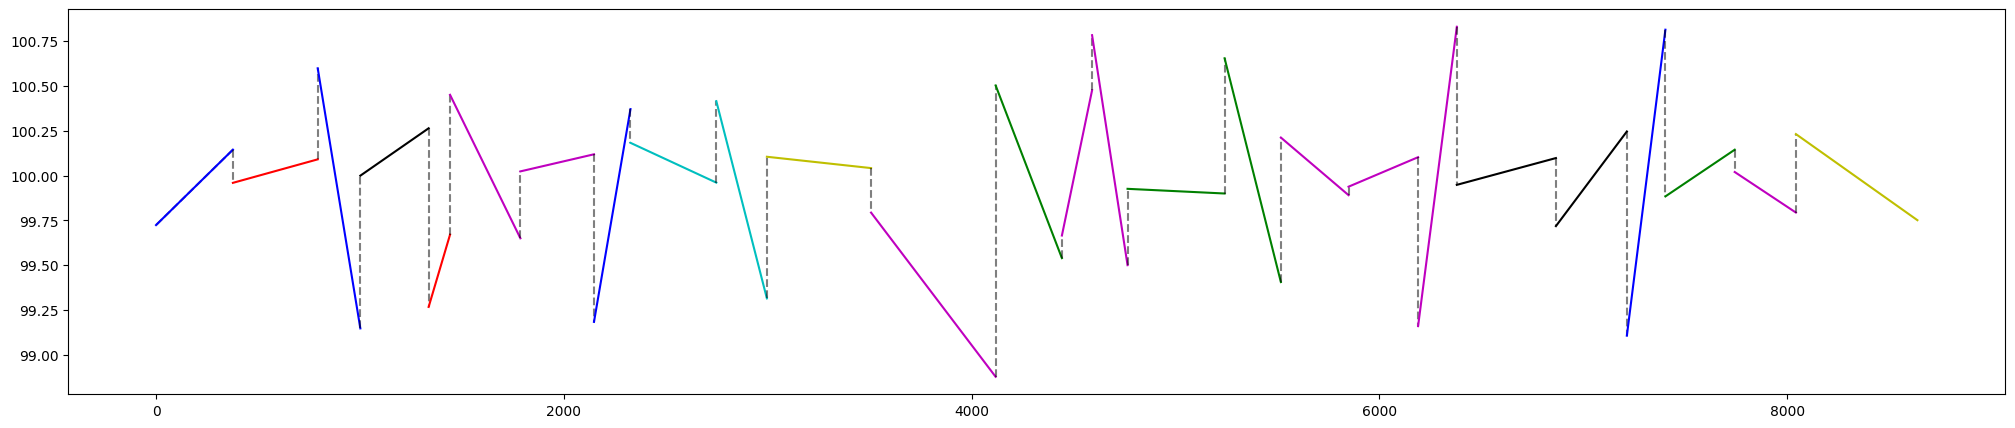

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.971644,0.599018,1.0,0.749232


In [71]:
max_error = 30
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [75]:
range_max_error_swab = (30,85)
best_swab = 50
time_avg_swab = (19.7+17.5+12.5)/3

# Conclusion

In [78]:
data = {
    'Id' : [9,9,9,9],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min(max_error)': [range_max_error_topdown[0],range_max_error_bottomup[0], range_max_error_sldw[0],range_max_error_swab[0]],
    'max(max_error)': [range_max_error_topdown[1],range_max_error_bottomup[1],range_max_error_sldw[1],range_max_error_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(in range)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [1,3,2,3]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min(max_error),max(max_error),Best,Time Average(in range),Accuracy,Precision,Recall,F1-score,Rank
0,9,Top-down,500,1000,1000,31.266667,0.992014,0.841379,1.0,0.913858,1
1,9,Bottom-up,30,200,100,5.533333,0.971644,0.599018,1.0,0.749232,3
2,9,Sliding-window,43,47,45,1.573333,0.985417,0.743902,1.0,0.853147,2
3,9,SWAB,30,85,50,16.566667,0.971644,0.599018,1.0,0.749232,3


# To exp

## Conclusion

In [79]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

## Feature _ Maxerror

In [80]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 9
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_max_error_topdown[0]
feature_max_error['Max(max_error)_Top_down'] = range_max_error_topdown[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_max_error_bottomup[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_max_error_bottomup[1]
feature_max_error['Min(max_error)_SLDW'] = range_max_error_sldw[0]
feature_max_error['Max(max_error)_SLDW'] = range_max_error_sldw[1]
feature_max_error['Min(max_error)_SWAB'] = range_max_error_swab[0]
feature_max_error['Max(max_error)_SWAB'] = range_max_error_swab[1]
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = best_swab

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [81]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,absolute_sum_of_changes,mean_abs_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,2,8640,102.151881,100.286884,212.017664,14.560826,95822.993645,11.091908,4.776042,62.598994,181.709748,50000,350000,30000,90000,35000,150000,30000,90000,60000
1,1,8640,104.621483,100.014344,442.227086,21.029196,4986.149682,0.577167,16.640276,98.129950,201.585487,50,850000,50,10100,10000,550000,50,12500,4975
2,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
3,4,8640,101.822061,101.317681,3.021211,1.738163,977.164373,0.113111,1.649976,99.734227,110.681462,1400,5000,0,100,400,1400,0,100,50
4,6,8640,104.766749,113.999449,5159.711223,71.831130,10003.014053,1.157890,-1.502673,-5.871039,202.953165,90000,5000000,25000,35000,40000,1000000,98,102,100
5,7,8640,102.895171,101.124826,13.689025,3.699868,975.726054,0.112944,-0.675163,94.723825,110.220648,30,450,2,25,30,140,2,25,10
6,8,8640,99.998457,99.999819,0.185628,0.430846,971.447477,0.112449,1.043627,98.715405,101.216021,5,30,1,4,1,10,1,4,2
7,9,8640,99.951207,99.996803,0.240128,0.490029,217.890120,0.025222,0.123460,98.939642,101.066830,500,1000,30,200,43,47,30,85,50
